In [1]:
import time
from dask.distributed import Client
import pystac_client
import planetary_computer
import stackstac
import numpy as np
import matplotlib.pyplot as plt
# If you don't have the libraries above, you should install them first.

## Xarray-compatible function example
- In this example, we get satellite data (Sentinel-2) from Planetary Computer and generate a time composite for the year 2023 (annual). We remove clouds, shadows, and snow using the SCL band and generate the quantile-based time composites for the Red, Green, and Blue bands (B04, B03, and B02). Monthly composites are also generated.
- The computation time of the xarray quantile implementation is compared to the time of the fastnanquantile implementation.
- Dask is used for the computations.

In [2]:
# Dask configuration
client = Client(n_workers=2, threads_per_worker=16, memory_limit='4GB')

### Dataset preparation

In [3]:
# STAC catalog from Planetary Computer
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [4]:
# Getting Sentinel-2 data for a specific area and time range
time_range = "2023-01-01/2023-12-31"
bbox = [-88.71831407017163, 33.567490337249566, -88.60236444086019, 33.641429881667435]

search = catalog.search(collections=["sentinel-2-l2a"], datetime=time_range,
                        bbox=bbox, query={"eo:cloud_cover": {"lt": 40}},
                        )
items = search.item_collection()
da = stackstac.stack(items, resolution=10, xy_coords="center",
                     assets=["B02", "B03", "B04", "SCL"], dtype=np.float32)
da

c:\Users\lb2211\.conda\envs\fastnanquantile\lib\site-packages\stackstac\prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


<xarray.DataArray 'stackstac-2cbf252501d2e6d3a76658d1684577aa' (time: 64,
                                                                band: 4,
                                                                y: 10980,
                                                                x: 10980)>
dask.array<fetch_raster_window, shape=(64, 4, 10980, 10980), dtype=float32, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/44)
  * time                                     (time) datetime64[ns] 2023-01-05...
    id                                       (time) <U54 'S2B_MSIL2A_20230105...
  * band                                     (band) <U3 'B02' 'B03' 'B04' 'SCL'
  * x                                        (x) float64 3e+05 ... 4.098e+05
  * y                                        (y) float64 3.8e+06 ... 3.69e+06
    s2:cloud_shadow_percentage               (time) float64 0.0 0.0 ... 0.0
    ...                                       ...
    proj:bbox                                object {300000.0, 3690240.0, 409...
    gsd                                      (band) float64 10.0 10.0 10.0 20.0
    common_name                              (band) object 'blue' ... None
    center_wavelength                        (band) object 0.49 0.56 0.665 None
    full_width_half_max                      (band) object 0.098 0.045 ... None
    epsg                                     int32 32616
Attributes:
    spec:        RasterSpec(epsg=32616, bounds=(300000, 3690240, 409800, 3800...
    crs:         epsg:32616
    transform:   | 10.00, 0.00, 300000.00|\n| 0.00,-10.00, 3800040.00|\n| 0.0...
    resolution:  10

In [5]:
# Getting only a subset of the image to speed up the processing
da_subset = da.isel(x=slice(0, 1024), y=slice(0, 1024))

In [6]:
# Applying a mask to remove clouds, cloud shadows, snow and no data values
filter_values = (0, 3, 8, 9, 10, 11),
mask = da_subset.sel(band="SCL").isin(filter_values)
masked_data = da_subset.where(~mask)
# Remove the SCL band
masked_data = masked_data.drop_sel(band=["SCL"])

In [7]:
# When using dask, to compute quantiles in the time dimension,
# all values from the time dimension must be in the same chunk.
# It's required for the xarray quantile function and also fastnanquantile function.
masked_data = masked_data.chunk({"time": -1})

In [8]:
# Before starting the benchmarks, let's download the data from Planetary Computer.
# The line below will download the data and store it in memory. It's done to remove
# the download time interference in the benchmarks.
masked_data = masked_data.load()

### Annual time composites

In [9]:
# Computing quantile with standard xarray implementation
start = time.time()
quantile_xarray = masked_data.quantile(q=0.6, dim="time")
quantile_xarray = quantile_xarray.compute()
print(f"Standard xarray implementation - Time elapsed: {time.time() - start} seconds")

Standard xarray implementation - Time elapsed: 100.7498095035553 seconds


In [10]:
# Computing quantile with fastnanquantile
from fastnanquantile import xrcompat

start = time.time()
quantile_fnq = xrcompat.xr_apply_nanquantile(masked_data, q=0.6, dim="time")
quantile_fnq = quantile_fnq.compute()
print(f"fasnanquantile implementation - Time elapsed: {time.time() - start} seconds")

fasnanquantile implementation - Time elapsed: 5.785555362701416 seconds


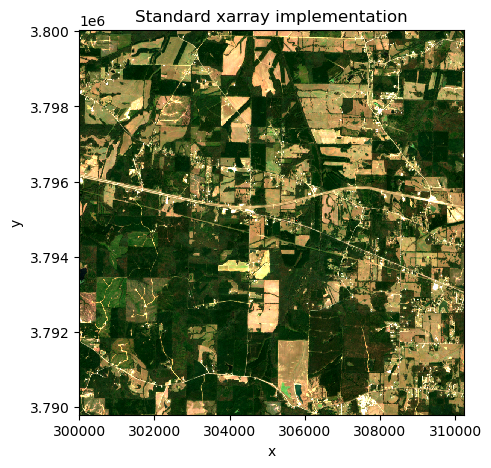

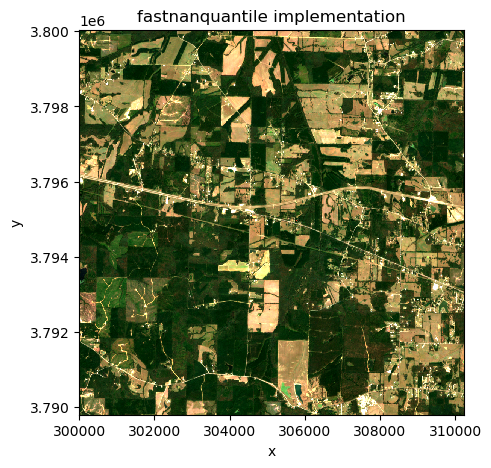

In [11]:
# Visualizing the results
quantile_xarray.sel(band=["B04", "B03", "B02"]).plot.imshow(figsize=(5, 5),robust=True,)
plt.gca().set_aspect("equal")
plt.title("Standard xarray implementation")
plt.show()
quantile_fnq.sel(band=["B04", "B03", "B02"]).plot.imshow(figsize=(5, 5),robust=True,)
plt.gca().set_aspect("equal")
plt.title("fastnanquantile implementation")
plt.show()

In [12]:
# Check if results are the same. If the results are not the same, an error will be raised
np.testing.assert_almost_equal(quantile_fnq.values, quantile_xarray.values, decimal=2)

### Monthly time composites using groupby

In [13]:
# First lets select only the B04 and smaller subset of the images to make the tests faster
masked_data = masked_data.sel(band='B04')
masked_data = masked_data.isel(y=slice(512), x=slice(512))

In [14]:
# Monthly composites using xarray
start = time.time()
xr_monthly_comp = masked_data.groupby("time.month").quantile(q=[0.6, 0.7]).compute()
print(f"Xarray implementation - Time elapsed: {time.time() - start} seconds")

c:\Users\lb2211\.conda\envs\fastnanquantile\lib\site-packages\numpy\lib\nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


Xarray implementation - Time elapsed: 95.09844279289246 seconds


In [15]:
start = time.time()
fnq_monthly_comp = masked_data.groupby("time.month").map(
    xrcompat.xr_apply_nanquantile, q=[0.6, 0.7], dim="time").compute()
print(f"fasnanquantile implementation - Time elapsed: {time.time() - start} seconds")

fasnanquantile implementation - Time elapsed: 0.507199764251709 seconds


In [16]:
# Check if results are the same. If the results are not the same, an error will be raised
np.testing.assert_almost_equal(fnq_monthly_comp.values, xr_monthly_comp.values, decimal=2)

## Final remarks
- Replacing the standard xarray implementation of the quantile function, which is based on numpy, with the implementation of fastnanquantile reduced the computation time from around 100 to 6 seconds (17x) in the annual composite and from 95 to 0.51 seconds (186x) in the monthly composites.
- The performance gain of fastnanquantile varies according to the input data shape. For time composites computation, we typically compute quantiles over the smallest axis (time dimension). In this scenario, fastnanquantile is expected to be significantly faster than the standard xarray implementation, as shown in this example. 